<a href="https://colab.research.google.com/github/mobarakol/computer_vision_tutorial/blob/main/sfm_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Structure from Motion (SFM)
Project Description: https://cmsc426.github.io/sfm/<br>
SRC: https://github.com/abhijitmahalle/structure-from-motion<br>
Report: https://github.com/abhijitmahalle/structure-from-motion/blob/master/Report.pdf<br>

This repository contains code to reconstruct a 3D scene and simultaneoulsy obtain the camera poses of a monocular camera with respect to the scene using the set of 6 images from the camera and their feature-point correspondence.

Following steps are involved:



*   Feature Matching and Outlier rejection using RANSAC
*   Estimating Fundamental Matrix
*   Estimating Essential Matrix from Fundamental Matrix
*   Estimate Camera Pose from Essential Matrix

Feature Matching using SIFT and RANSAC

<img src="https://user-images.githubusercontent.com/90370308/222005261-3c35443a-a23e-4ad1-9f88-b6f92a126ba5.png" width="400"/>





In [1]:
!git clone https://github.com/abhijitmahalle/structure-from-motion.git
%cd structure-from-motion/Code

Cloning into 'structure-from-motion'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 60 (delta 4), reused 53 (delta 2), pack-reused 0
Unpacking objects: 100% (60/60), 40.69 MiB | 6.20 MiB/s, done.
/content/structure-from-motion/Code


In [7]:
import numpy as np
import cv2
import glob
from os.path import exists
import argparse
from distutils.util import strtobool
from scipy.spatial.transform import Rotation 
from GetData import *
from GetInliersRANSAC import *
import matplotlib.pyplot as plt
from EssentialMatrixFromFundamentalMatrix import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
from NonlinearTriangulation import *
from Plotting import *
from PnPRANSAC import *
from NonlinearPnP import *
from BundleAdjustment import *

def create_src_dst(img_src_to_dst):
    src_pts = []#img_1to2[1][1]
    dst_pts = []
    for i in range(len(img_src_to_dst)):
        a = img_src_to_dst[i][1]
        b = img_src_to_dst[i][2]
        src_pts.append(a)
        dst_pts.append(b)
    src_pts = np.asarray(src_pts)
    dst_pts = np.asarray(dst_pts)
    return src_pts, dst_pts

def read_match_file(image_number, file4_lines, count):
    im_1to2 = []
    #im_to_dest = []
    for i in range(1,count+1):
        num_of_matches = int(file4_lines[i][0])
        if num_of_matches == 2:
            _, r_value, g_value, b_value, x_cord, y_cord, match_image_index1, match_x_cord2, match_y_cord2 = file4_lines[i].strip().split(' ')
            r_value = int(r_value)
            g_value = int(g_value)
            b_value = int(b_value)
            x_cord = float(x_cord)
            y_cord = float(y_cord)
            match_image_index1 = int(match_image_index1)
            match_x_cord2 = float(match_x_cord2)
            match_y_cord2 = float(match_y_cord2)
            intensity_val = (r_value, g_value, b_value)
            im1_cord = (x_cord, y_cord)
            im2_cord = (match_x_cord2, match_y_cord2)
            
            if (image_number == 1 and match_image_index1 == 2):
                im_1to2.append([intensity_val,im1_cord, im2_cord])
        
        if num_of_matches == 3:
            _, r_value, g_value, b_value, x_cord, y_cord, match_image_index1, match_x_cord2, match_y_cord2, match_image_index2, match_x_cord3, match_y_cord3 = file4_lines[i].strip().split(' ')
            match_image_index2 = int(match_image_index2)
            match_x_cord3 = float(match_x_cord3)
            match_y_cord3 = float(match_y_cord3)
            r_value = int(r_value)
            g_value = int(g_value)
            b_value = int(b_value)
            x_cord = float(x_cord)
            y_cord = float(y_cord)
            match_image_index1 = int(match_image_index1)
            match_x_cord2 = float(match_x_cord2)
            match_y_cord2 = float(match_y_cord2)
            intensity_val = (r_value, g_value, b_value)
            im1_cord = (x_cord, y_cord)
            im2_cord = (match_x_cord2, match_y_cord2)
            
            if (image_number == 1 and match_image_index1 == 2):
                im_1to2.append([intensity_val,im1_cord, im2_cord])
            if (image_number == 1 and match_image_index2 == 2):
                im_1to2.append([intensity_val,im1_cord, im3_cord])       

        if num_of_matches == 4:
            _, r_value, g_value, b_value, x_cord, y_cord, match_image_index1, match_x_cord2, match_y_cord2, match_image_index2, match_x_cord3, match_y_cord3, match_image_index3, match_x_cord4, match_y_cord4 = file4_lines[i].strip().split(' ')
            match_image_index3 = int(match_image_index3)
            match_x_cord4 = float(match_x_cord4)
            match_y_cord4 = float(match_y_cord4)

            match_image_index2 = int(match_image_index2)
            match_x_cord3 = float(match_x_cord3)
            match_y_cord3 = float(match_y_cord3)
            r_value = int(r_value)
            g_value = int(g_value)
            b_value = int(b_value)
            x_cord = float(x_cord)
            y_cord = float(y_cord)
            match_image_index1 = int(match_image_index1)
            match_x_cord2 = float(match_x_cord2)
            match_y_cord2 = float(match_y_cord2)
            intensity_val = (r_value, g_value, b_value)
            im1_cord = (x_cord, y_cord)
            im2_cord = (match_x_cord2, match_y_cord2)
            im3_cord = (match_x_cord3, match_y_cord3)
            im4_cord = (match_x_cord4, match_y_cord4)
            
            if (image_number == 1 and match_image_index1 == 2):
                im_1to2.append([intensity_val,im1_cord, im2_cord])
            if (image_number == 1 and match_image_index2 == 2):
                im_1to2.append([intensity_val,im1_cord, im3_cord])
            if (image_number == 1 and match_image_index3 == 2):
                im_1to2.append([intensity_val,im1_cord, im4_cord])

        if num_of_matches == 5:
            _, r_value, g_value, b_value, x_cord, y_cord, match_image_index1, match_x_cord2, match_y_cord2, match_image_index2, match_x_cord3, match_y_cord3, match_image_index3, match_x_cord4, match_y_cord4, match_image_index4, match_x_cord5, match_y_cord5 = file4_lines[i].strip().split(' ')
            match_image_index4 = int(match_image_index4)
            match_x_cord5 = float(match_x_cord5)
            match_y_cord5 = float(match_y_cord5)
            
            match_image_index3 = int(match_image_index3)
            match_x_cord4 = float(match_x_cord4)
            match_y_cord4 = float(match_y_cord4)

            match_image_index2 = int(match_image_index2)
            match_x_cord3 = float(match_x_cord3)
            match_y_cord3 = float(match_y_cord3)
            r_value = int(r_value)
            g_value = int(g_value)
            b_value = int(b_value)
            x_cord = float(x_cord)
            y_cord = float(y_cord)
            match_image_index1 = int(match_image_index1)
            match_x_cord2 = float(match_x_cord2)
            match_y_cord2 = float(match_y_cord2)
            intensity_val = (r_value, g_value, b_value)
            im1_cord = (x_cord, y_cord)
            im2_cord = (match_x_cord2, match_y_cord2)
            im3_cord = (match_x_cord3, match_y_cord3)
            im4_cord = (match_x_cord4, match_y_cord4)
            im5_cord = (match_x_cord5, match_y_cord5)

            if (image_number == 1 and match_image_index1 == 2):
                im_1to2.append([intensity_val,im1_cord, im2_cord])
            if (image_number == 1 and match_image_index2 == 2):
                im_1to2.append([intensity_val,im1_cord, im3_cord])
            if (image_number == 1 and match_image_index3 == 2):
                im_1to2.append([intensity_val,im1_cord, im4_cord])
            if (image_number == 1 and match_image_index4 == 2):
                im_1to2.append([intensity_val,im1_cord, im5_cord])

    return im_1to2

[[-2.12959882e-07 -9.82080020e-06  2.75965978e-03]
 [ 1.20285741e-05 -6.86550113e-07 -3.90274995e-03]
 [-4.46212992e-03  1.89118218e-03  9.99976832e-01]]
[[-0.01082897 -0.72431025 -0.26590966]
 [ 0.8808352  -0.05612577  0.44911258]
 [ 0.15204231 -0.61718946 -0.14066587]]
85
0
1299
0
Linear Triangulation 30.47194229050827


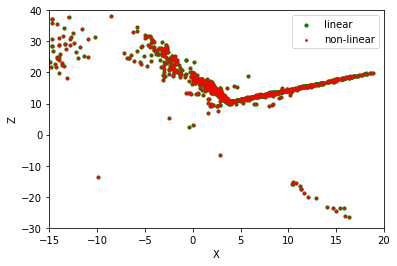

In [9]:
k =  np.array([[568.996140852, 0 ,643.21055941],
     [0, 568.988362396, 477.982801038],
     [0 ,0,1]])
    
Parser = argparse.ArgumentParser()
Parser.add_argument('--Path', default="../Data/", help='Path to data folder')
Parser.add_argument('--Filtered', default="False",  type=lambda x: bool(strtobool(x)),help='If filtered data is available')
Args = Parser.parse_args([])
folder = Args.Path
filtered_avail = Args.Filtered
images = [cv2.imread(img) for img in sorted(glob.glob(str(folder)+'/*.jpg'))]
n_imgs = 6

if filtered_avail:
    fundamental_matrix = np.load('fmatrix.npy',allow_pickle=True)
else:
    fundamental_matrix = np.zeros(shape=(6, 6), dtype=object)
    for i in range(n_imgs-1):
        for j in range(i+1, n_imgs):

            #print("RANSAC for image" +str(i+1)+ "and" +str(j+1))
            pair_num = str(i+1)+str(j+1)
            file_name = "matches" +pair_num+".txt"
            if exists(folder+"/"+file_name):
                points1,points2 = get_pts(folder, file_name)
                point1_fil,point2_fil,F_best = ransac(points1,points2)
                save_file_name = "ransac"+pair_num+".txt"
                for idx in range(len(point1_fil)):
                    save_file = open(save_file_name, 'a')
                    save_file.write(str(point1_fil[idx][0])+ " " + str(point1_fil[idx][1]) + " " + str(point2_fil[idx][0]) + " " + str(point2_fil[idx][1]) + "\n")
                    save_file.close()

                fundamental_matrix[i,j] = F_best.reshape((3,3))



                display_ransac(images[i], images[j], point1_fil,point2_fil,points1,points2,pair_num)
            else:
                continue
                
              

#image number 1
file_name = "../Data/matching" +str(1)+".txt"
file4 = open(file_name, 'r')
file4_lines = []
for count,line in enumerate(file4):
    file4_lines.append(line)
I = np.identity(3)

# 1) Import matches of first image with all other images
img_1to2 = read_match_file(1, file4_lines, count)

# 2) Implement RANSAC to remove outliers from original matches
points1, points2 = create_src_dst(img_1to2)

point1_fil, point2_fil, F_best = ransac(points1,points2)
F_matrix = F_best
print(F_matrix)

#Estimate Essential Matrix from Fundamental Matrix
E_matrix = estimate_Essentialmatrix(k,F_matrix)
print(E_matrix)

#Extract Poses of Camera (will be 4)
R_set, T_set = get_RTset(E_matrix)

#Linear Triangulation 
point3D_set = linear_triangulation(R_set,T_set, point1_fil, point2_fil, k)

#Get pose of camera using cheirality condition
R_best, T_best,X_ ,index= extract_pose(R_set, T_set, point3D_set)

#Non-Linear Triangulation
R1 = np.identity(3)
T1 = np.zeros((3,1))
X_nl = non_linear_triangulation(R1, T1, R_best, T_best, point1_fil, point2_fil, X_, k)
plot_linear_nonlinear(X_,X_nl,index)

#calculate error
error_prior = mean_error(R1,T1,R_best,T_best,point1_fil,point2_fil,X_,k)
print("Linear Triangulation",error_prior)


# # #Linear Triangulation 
# point3D_set = linear_triangulation(R_set,T_set,point1_fil,point2_fil,k)
# plot_poses(R_set,T_set,point3D_set)
# error_post = mean_error(R1,T1,R_best,T_best,point1_fil,point2_fil,X_nl,k)
# print("Non-linear triangulation",error_post)
